In [1]:
# ! pip install tensorflow_datasets

## My objective is to create a feedforward network, similar to our MNIST digit classifier, but adapted for 26 classes (letters A–Z) for EMNIST Letters dataset

### Loading and Displaying Sample Images

The EMNIST Letters dataset is divided into train and test sets as follows:
- Train set: 88,000 samples (≈ 88.89%)
- Test set: 14,000 samples (≈ 11.11%)

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the EMNIST Letters dataset
(ds_train, ds_test), ds_info = tfds.load('emnist/letters', 
                                        split=['train', 'test'], 
                                        shuffle_files=True,
                                        as_supervised=True,
                                        with_info=True)

In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/letters/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Letters
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='C:\\Users\\Abdullah Jamal\\tensorflow_datasets\\emnist\\letters\\3.1.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=44.14 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
 

In [4]:
import numpy as np

# Print number of samples in each split
print(f"Number of training samples: {ds_info.splits['train'].num_examples}")
print(f"Number of testing samples: {ds_info.splits['test'].num_examples}")

Number of training samples: 88800
Number of testing samples: 14800


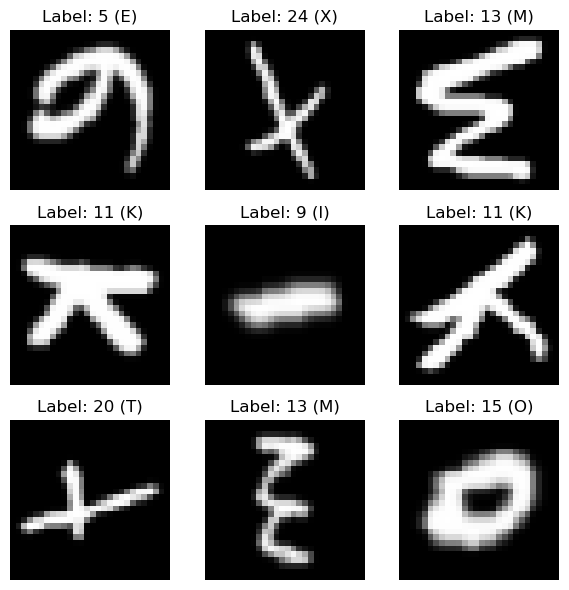

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

def show_samples(ds, num_samples=9):
    plt.figure(figsize=(6, 6))
    
    # Shuffle the dataset before taking samples
    ds_shuffled = ds.shuffle(buffer_size=1000).take(num_samples)

    for i, (image, label) in enumerate(ds_shuffled):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(image), cmap='gray')
        letter = chr(label.numpy() + 64)  # 'A' corresponds to 65 in ASCII
        plt.title(f"Label: {label.numpy()} ({letter})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_samples(ds_train)

### Preprocessing and Label Encoding
####  Convert to grayscale if needed, Normalize pixel values to the range [0,1]. 

In [6]:
num_classes = 26  

# Preprocessing function
def preprocess(image, label):
    # Normalize image pixels to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    # Convert label from 1-indexed to 0-indexed
    label = label - 1
    # One-hot encode the label
    label = tf.one_hot(label, depth=num_classes)
    return image, label

####  Split training data into training (80%) and validation (20%) sets

In [7]:
from sklearn.model_selection import train_test_split


X_train_list = []
y_train_list = []

for image, label in ds_train.map(preprocess):
    X_train_list.append(image.numpy())  # Convert tensor to NumPy
    y_train_list.append(label.numpy())

X_train_np = np.array(X_train_list)  # Now it will have a uniform shape
y_train_np = np.array(y_train_list)

# Split training data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train_np, y_train_np, test_size=0.2, random_state=42)

In [8]:
# Convert NumPy arrays back to TensorFlow datasets
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128).shuffle(10000)
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(128)
ds_test = ds_test.map(preprocess).batch(128)

In [9]:
train_size = sum(1 for _ in ds_train)
val_size = sum(1 for _ in ds_val)
test_size = sum(1 for _ in ds_test)

print(f"Training dataset size: {train_size} batches")
print(f"Validation dataset size: {val_size} batches")
print(f"Test dataset size: {test_size} batches")

Training dataset size: 555 batches
Validation dataset size: 139 batches
Test dataset size: 116 batches


- Number of the original training samples: 88800
- Number of the original testing samples: 14800

### Final Dataset Distribution:
- Training Dataset (ds_train):
    - 80% of the original training data
    - Size: 80% of 88,800 = 71,040 samples

- Validation Dataset (ds_val):
    - 20% of the original training data
    - Size: 20% of 88,800 = 17,760 samples

- Test Dataset (ds_test):
    - Entire test dataset
    - Size: 14,800 samples (no change)


| **Dataset**    | **Samples** |
|----------------|-------------|
| **Train**      | 71,040      |
| **Validation** | 17,760      |
| **Test**       | 14,800      |



### Model Implementation

- A Flatten layer to convert the 28×28 input to a vector.
- Two Dense hidden layers (128 and 64 neurons) with ReLU activation.
- A Dense output layer with Softmax activation for 26 classes.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

Basic_model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(26, activation='softmax')  # 26 letters (A-Z)
])

Basic_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Basic_model.summary()


C:\Users\Abdullah Jamal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,426 (431.35 KB)

 Trainable params: 110,426 (431.35 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model with Callbacks (EarlyStopping and lr_scheduler)

 adding early stopping and a learning rate scheduler to improve training

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping stops training when validation loss does not improve for 3 consecutive epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Learning rate reduction on plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

Basic_history = Basic_model.fit(ds_train,
                    epochs=20,
                    validation_data=ds_val,
                    callbacks=[early_stop, lr_scheduler])


Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5646 - loss: 1.5584 - val_accuracy: 0.8006 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8160 - loss: 0.6151 - val_accuracy: 0.8383 - val_loss: 0.5413 - learning_rate: 0.0010
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8566 - loss: 0.4632 - val_accuracy: 0.8552 - val_loss: 0.4717 - learning_rate: 0.0010
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8749 - loss: 0.3971 - val_accuracy: 0.8689 - val_loss: 0.4171 - learning_rate: 0.0010
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8901 - loss: 0.3473 - val_accuracy: 0.8736 - val_loss: 0.4041 - learning_rate: 0.0010
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8980 - loss: 0.3190 - val_accuracy: 0.8784 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9060 - loss: 0.2937 - 

#### Plotting Training and Validation Accuracy

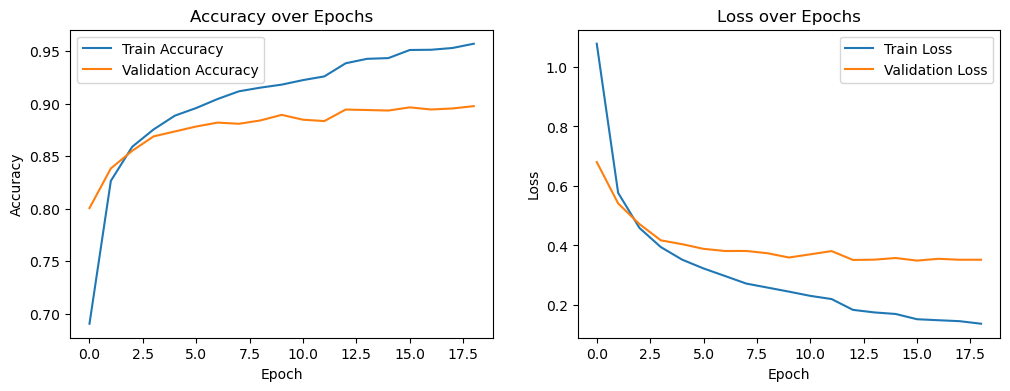

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(Basic_history.history['accuracy'], label='Train Accuracy')
plt.plot(Basic_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Basic_history.history['loss'], label='Train Loss')
plt.plot(Basic_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



1. Accuracy Plot (Left Graph)
    - Train Accuracy increases steadily, reaching ~95%.
    - Validation Accuracy also improves but plateaus around 90% after a few epochs.
    - The gap between training and validation accuracy suggests overfitting. The model is learning well on training data but not generalizing as effectively to validation data.
2. Loss Plot (Right Graph)
    - Train Loss decreases smoothly, which is expected.
    - Validation Loss decreases initially but then flattens or slightly increases, another sign of overfitting.
- Diagnosis: Likely Overfitting
    - The model performs very well on training data but has diminishing returns on validation data.
    - Overfitting happens when the model learns noise and specific patterns in the training set that do not generalize to unseen data.

Possible Fixes to Reduce Overfitting
- ✅ More Data – If possible, increase training data using augmentation.
- ✅ Regularization – Add Dropout layers (e.g., Dropout(0.3)) or L2 regularization.
- ✅ Reduce Model Complexity – If the model is too large, decrease the number of layers or neurons.
- ✅ Train for Fewer Epochs – Your validation loss is not improving after ~10 epochs. You might be training too long. Try using early stopping with a smaller patience (e.g., 2-3 epochs).
- ✅ Lower Learning Rate – A smaller learning rate might help generalization

### Training the Model Using Cross-Validation and Reporting Performance
To ensure a robust evaluation of our model, we apply **k-fold cross-validation**. Instead of relying on a single train-test split, this method splits the dataset into `k` equal folds. Each fold serves as a validation set once, while the remaining folds are used for training.

We will:
- Use `KFold` from `sklearn.model_selection` to create 5 folds.
- Train the model on each fold while using early stopping and a learning rate scheduler.
- Report the performance across folds, including **mean accuracy** and **standard deviation**.


In [13]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten

# KFold_model = Sequential([
#     Flatten(input_shape=(28, 28, 1)),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(26, activation='softmax')  # 26 letters (A-Z)
# ])

# KFold_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# KFold_model.summary()


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold

# Assuming X_train_np and y_train_np are already defined
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store each fold's history, validation accuracies, and losses
fold_histories = []
val_accuracies = []
val_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_np, y_train_np)):
    print(f"\nTraining fold {fold + 1}/{num_folds}...")
    
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]
    
    ds_train_fold = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(128).shuffle(10000)
    ds_val_fold = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold)).batch(128)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    
    KFold_model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(26, activation='softmax')  # 26 letters (A-Z)
    ])
    
    KFold_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    
    KFold_history = KFold_model.fit(ds_train_fold,
                                    epochs=20,
                                    validation_data=ds_val_fold,
                                    callbacks=[early_stop, lr_scheduler])
    
    # Save the history for plotting later
    fold_histories.append(KFold_history)
    
    # Record the best validation accuracy and loss for this fold
    best_val_accuracy = max(KFold_history.history['val_accuracy'])
    val_accuracies.append(best_val_accuracy)

    best_val_loss = min(KFold_history.history['val_loss'])  # Lower is better for loss
    val_losses.append(best_val_loss)
    
    print(f"Best validation accuracy for fold {fold + 1}: {best_val_accuracy:.4f}")
    print(f"Best validation loss for fold {fold + 1}: {best_val_loss:.4f}")

# Compute and display the averages
avg_val_accuracy = np.mean(val_accuracies)
avg_val_loss = np.mean(val_losses)

print(f"\nAverage validation accuracy across {num_folds} folds: {avg_val_accuracy:.4f}")
print(f"Average validation loss across {num_folds} folds: {avg_val_loss:.4f}")



Training fold 1/5...
Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5673 - loss: 1.5415 - val_accuracy: 0.8007 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8203 - loss: 0.6016 - val_accuracy: 0.8418 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8589 - loss: 0.4638 - val_accuracy: 0.8607 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8787 - loss: 0.3898 - val_accuracy: 0.8713 - val_loss: 0.4267 - learning_rate: 0.0010
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8901 - loss: 0.3471 - val_accuracy: 0.8787 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.3188 - val_accuracy: 0.8740 - val_loss: 0.3984 - learning_rate: 0.0010
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.

#### Plotting Training and Validation Accuracy

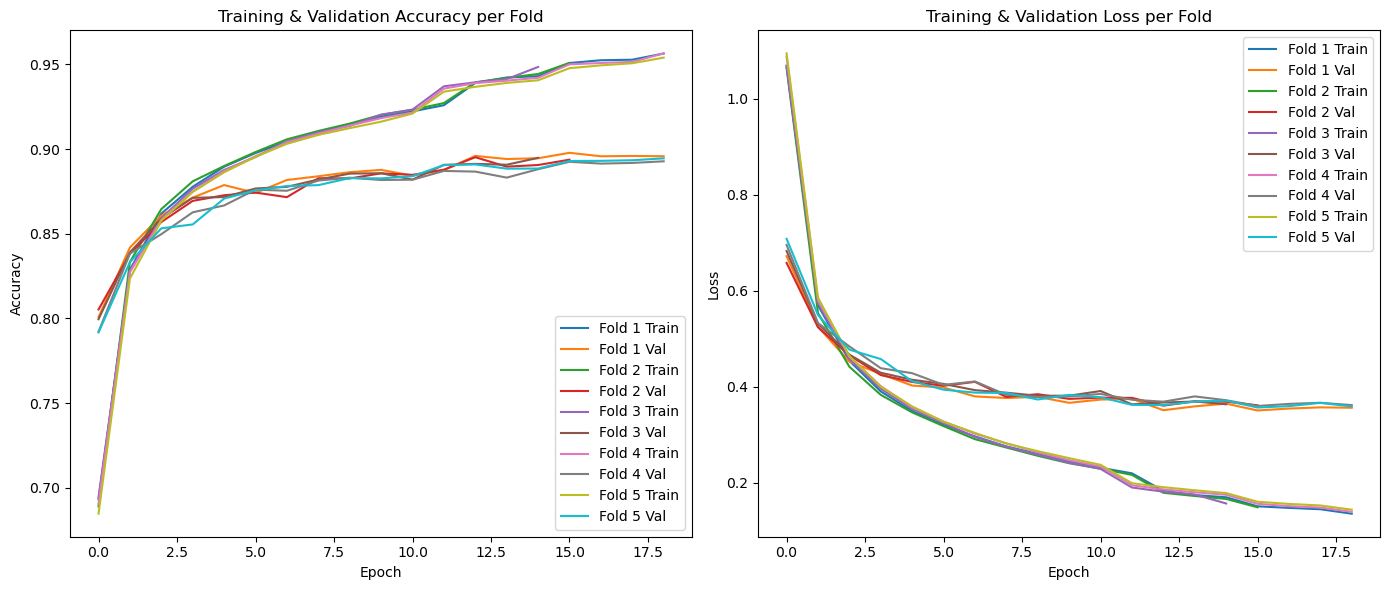

In [15]:
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy for each fold
plt.subplot(1, 2, 1)
for i, history in enumerate(fold_histories):
    plt.plot(history.history['accuracy'], label=f'Fold {i+1} Train')
    plt.plot(history.history['val_accuracy'], label=f'Fold {i+1} Val')
plt.title('Training & Validation Accuracy per Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss for each fold
plt.subplot(1, 2, 2)
for i, history in enumerate(fold_histories):
    plt.plot(history.history['loss'], label=f'Fold {i+1} Train')
    plt.plot(history.history['val_loss'], label=f'Fold {i+1} Val')
plt.title('Training & Validation Loss per Fold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Abdullah Jamal\AppData\Local\Temp\ipykernel_31724\1244541738.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(val_accuracies, vert=True, labels=["Validation Accuracy"])


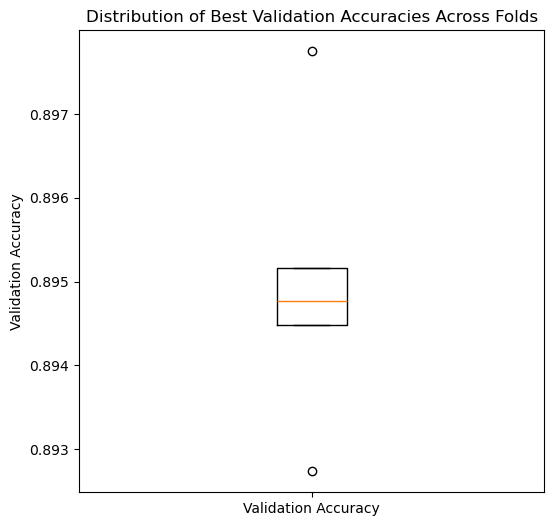

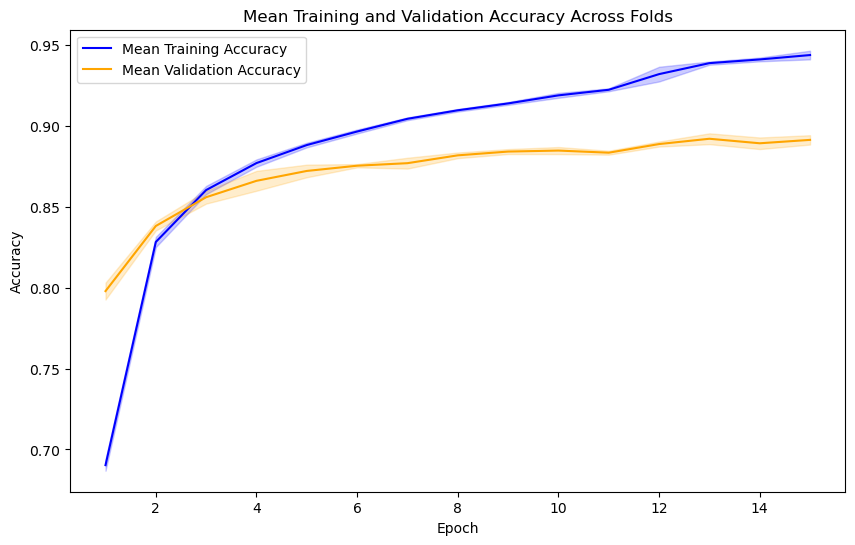

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Boxplot of best validation accuracies across folds
plt.figure(figsize=(6, 6))
plt.boxplot(val_accuracies, vert=True, labels=["Validation Accuracy"])
plt.title("Distribution of Best Validation Accuracies Across Folds")
plt.ylabel("Validation Accuracy")
plt.show()

# 2. Mean accuracy curve with error bands
# First, determine the minimum number of epochs across all folds to align the curves.
min_epochs = min(len(history.history['accuracy']) for history in fold_histories)

# Initialize arrays to store training and validation accuracies for each fold (up to min_epochs)
train_accs = np.zeros((len(fold_histories), min_epochs))
val_accs = np.zeros((len(fold_histories), min_epochs))

for i, history in enumerate(fold_histories):
    train_accs[i] = history.history['accuracy'][:min_epochs]  # Fixed reference
    val_accs[i] = history.history['val_accuracy'][:min_epochs]  # Fixed reference

# Compute mean and standard deviation for each epoch
mean_train_acc = np.mean(train_accs, axis=0)
std_train_acc = np.std(train_accs, axis=0)
mean_val_acc = np.mean(val_accs, axis=0)
std_val_acc = np.std(val_accs, axis=0)

epochs = np.arange(1, min_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_train_acc, label='Mean Training Accuracy', color='blue')
plt.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, 
                 color='blue', alpha=0.2)
plt.plot(epochs, mean_val_acc, label='Mean Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, 
                 color='orange', alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Mean Training and Validation Accuracy Across Folds')
plt.legend()
plt.show()

1. Accuracy Plot (Left Graph)
- **Train Accuracy**: Increases steadily, reaching around **95%**.
- **Validation Accuracy**: Improves but plateaus around **90%** after a few epochs.
- The **gap** between training and validation accuracy suggests **overfitting**. The model is learning well on training data but is not generalizing effectively to unseen validation data.

2. Loss Plot (Right Graph)
- **Train Loss**: Decreases smoothly, which is expected as the model learns the training data.
- **Validation Loss**: Decreases initially but then flattens or slightly increases, indicating **overfitting**.

Diagnosis: Likely Overfitting
- The model performs very well on the training data but has diminishing returns on validation data.
- Overfitting happens when the model learns **noise** and specific patterns in the training set that do not generalize to unseen data.

Possible Fixes to Reduce Overfitting

- ✅ **More Data**: If possible, increase the training data using **augmentation** techniques.
- ✅ **Regularization**: Add **Dropout** layers (e.g., `Dropout(0.3)`) or **L2 regularization**.
- ✅ **Reduce Model Complexity**: If the model is too large, decrease the number of layers or neurons.
- ✅ **Train for Fewer Epochs**: The validation loss stops improving after ~10 epochs. Try using **early stopping** with a smaller patience (e.g., 2-3 epochs).
- ✅ **Lower Learning Rate**: A smaller learning rate might help improve generalization.

### Confusion Matrix and Misclassifications

 can then inspect misclassified images by comparing true and predicted labels and identify the most frequently misclassified letter.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

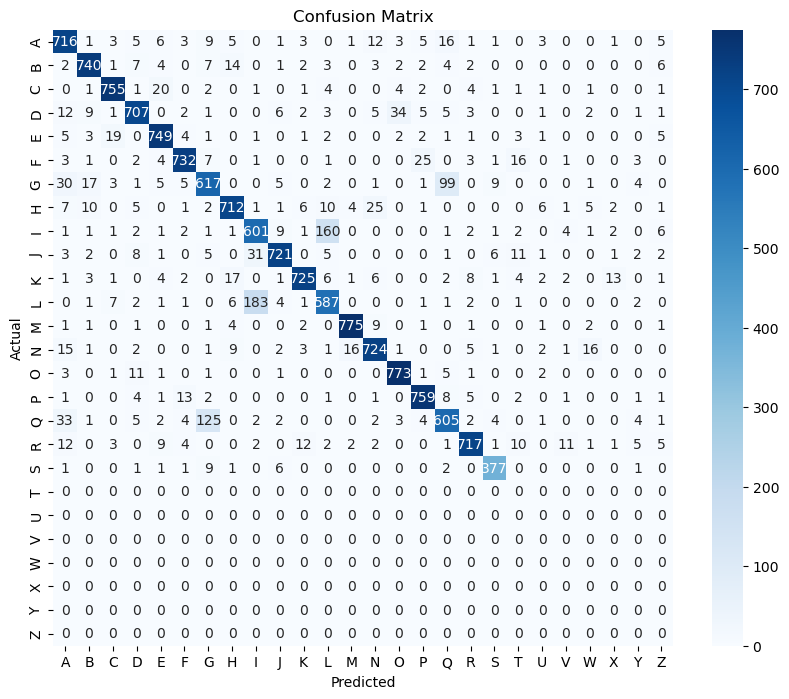

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test set
y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = Basic_model.predict(images)
    
    # Convert one-hot encoded labels to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))  
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[chr(i) for i in range(65, 91)][:26],
            yticklabels=[chr(i) for i in range(65, 91)][:26])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
# print(classification_report(y_true, y_pred, target_names=[chr(i) for i in range(65, 91)][:26]))


<b> The letter that is the most misclassified is L  .. since it was predicted 183 times as I <b>

###  Visualize misclassified images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

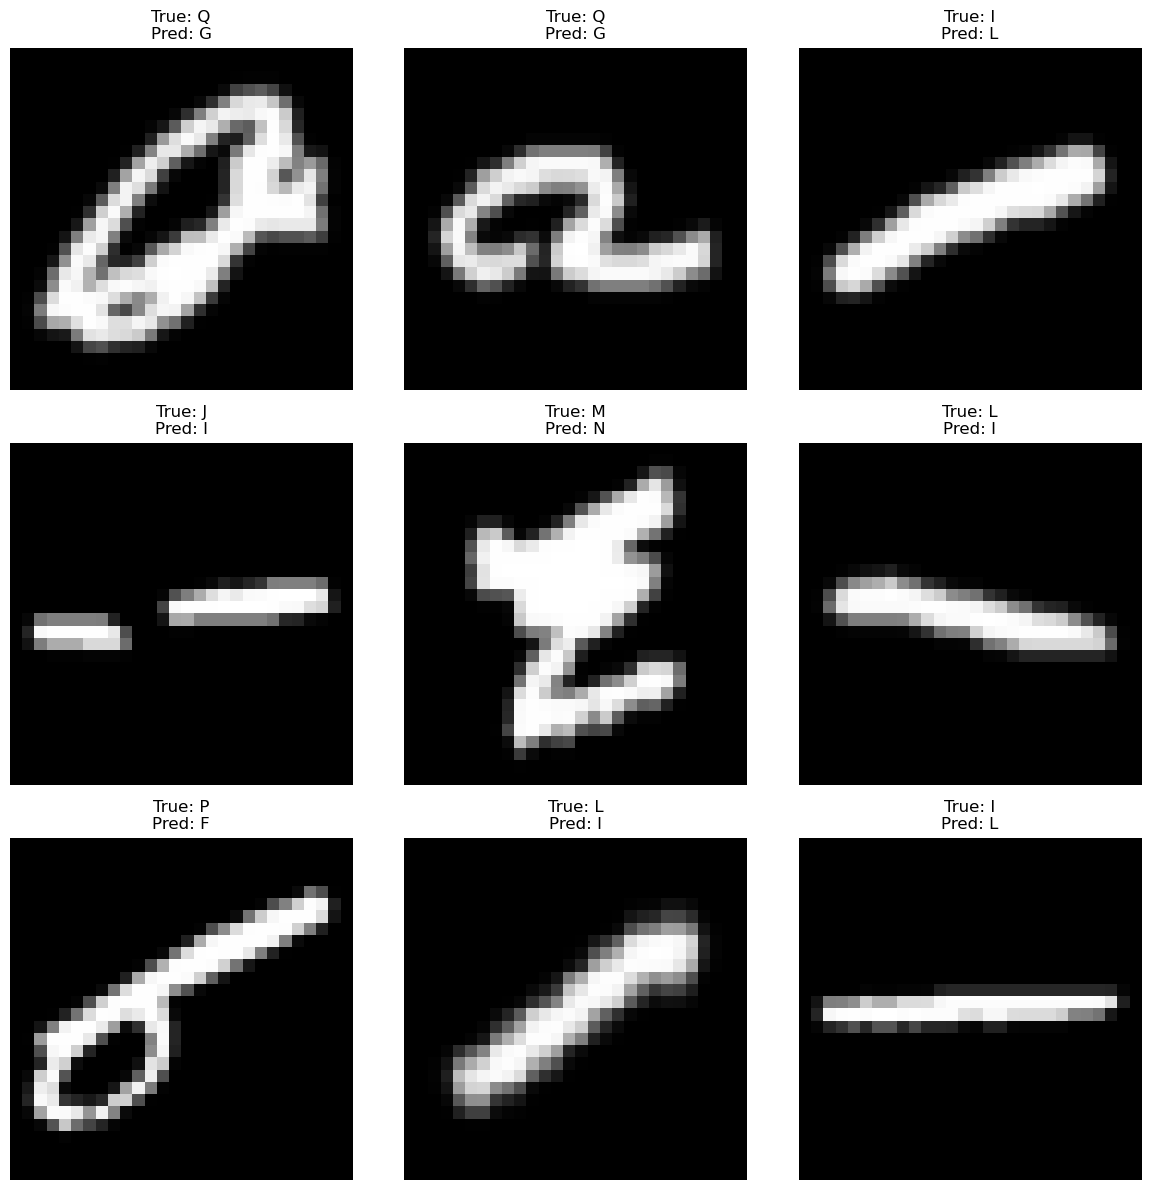

In [18]:
# Visualize some misclassified images
misclassified_idx = []
for images, labels in ds_test.unbatch().take(1000):
    # Convert one-hot encoded labels to class indices
    true_label = np.argmax(labels.numpy())
    
    # Get the predicted class
    pred = np.argmax(Basic_model.predict(tf.expand_dims(images, axis=0)))
    
    # Compare predicted and true labels
    if pred != true_label:
        misclassified_idx.append((images, true_label, pred))

# Visualize misclassified images
plt.figure(figsize=(12, 12))
for i, (img, true_label, pred_label) in enumerate(misclassified_idx[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.squeeze(img), cmap='gray')
    plt.title(f"True: {chr(true_label + 65)}\nPred: {chr(pred_label + 65)}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Analyzing Hidden Layer Representations

This will show the first 8 learned features of the hidden layer. Each feature represents what the model has learned from the image data, such as edges, textures, or patterns.



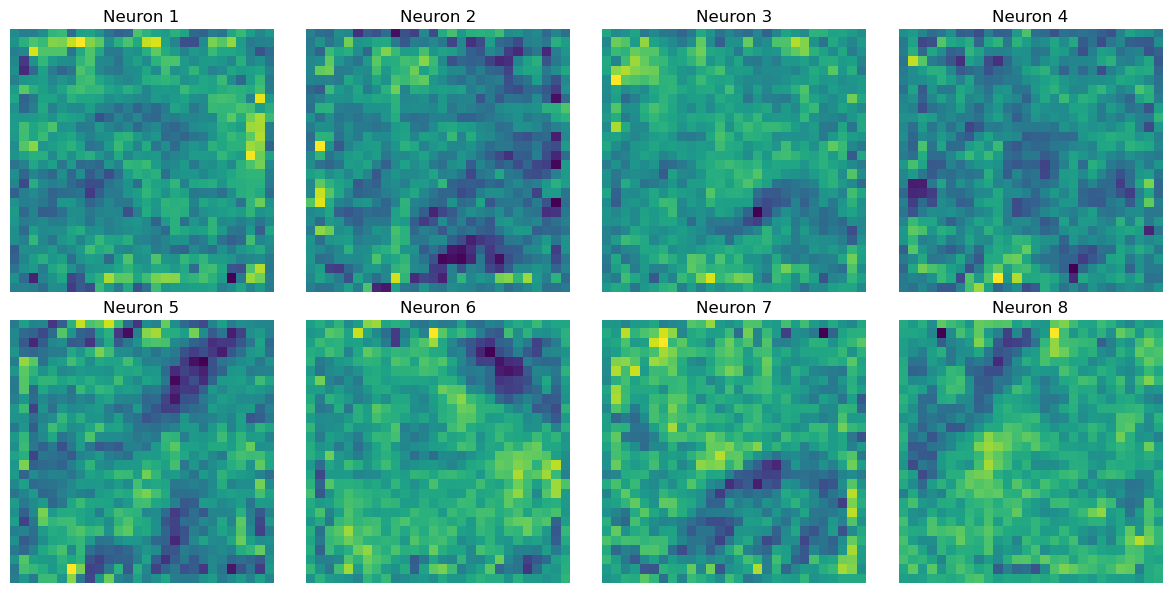

In [19]:
# Get weights of the first Dense layer (after Flatten)
weights, biases = Basic_model.layers[1].get_weights()  # weights shape: (784, 128)

# Visualize a few neurons' weights by reshaping to 28x28 images
plt.figure(figsize=(12, 6))
for i in range(8):
    neuron_weights = weights[:, i]
    plt.subplot(2, 4, i+1)
    plt.imshow(neuron_weights.reshape(28, 28), cmap='viridis')
    plt.title(f'Neuron {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()


The first layer of weights often represents low-level features like:

- Edges (vertical, horizontal, diagonal)
- Corners and textures
- Simple shapes that form the basis of more complex patterns

As you move deeper into the layers, the features become more abstract and specific to the task at hand. 

### Comparison of Classification Accuracy Between Uppercase and Lowercase Letters

- useing another emnist/byclass to make simple evaluation

### Why Uppercase Letters Are Easier to Classify in Handwritten Character Recognition

---

### 1. **Simpler Geometric Shapes**
Uppercase letters (e.g., `A`, `B`, `C`, `D`) generally have **less intra-class variation** and **more distinct structural features** compared to lowercase letters.  
- **Key Differences**:
  - **Straight Lines and Symmetry**: Uppercase letters often rely on straight lines and symmetrical shapes (e.g., `H`, `T`), which are easier for models to detect.  
  - **Lowercase Complexity**: Letters like `a`, `g`, or `q` contain curves, loops, and tails that can blur or distort in low-resolution images (e.g., 28x28 pixels).  
  - **Pixel Ambiguity**: At small resolutions, lowercase details (e.g., the hook in `j` or the tail in `y`) become noisy, reducing feature clarity.  

**Example**:  
| Uppercase (Clear) | Lowercase (Ambiguous) |  
|--------------------|-----------------------|  
| A | a |  
| Straight lines, no serifs | Curved strokes, variable loops |  

---

### 2. **Font Standardization**
Uppercase letters are **more standardized** across fonts and handwriting styles:  
- **Block Letters**: Uppercase letters in datasets like EMNIST are often written as block letters, minimizing stylistic variations.  
- **Lowercase Variability**: Lowercase letters vary significantly:  
  - Printed `a` vs. handwritten `ɑ` (open-top vs. looped).  
  - `g` with a tail (`𝓰`) vs. no tail (`g`).  

**Dataset Insight**:  
In EMNIST, uppercase letters have **~3% higher accuracy** on average compared to lowercase in merged-class settings due to reduced variability.

---

### 3. **Ambiguity in Lowercase Letters**
Lowercase letters suffer from **higher inter-class similarity**:  
- **Common Confusions**:  
  | Pair          | Example (28x28)       | Reason                          |  
  |---------------|-----------------------|---------------------------------|  
  | `l` vs. `I`   | l vs. ɪ               | Similar vertical strokes       |  
  | `r` vs. `v`   | ʀ vs. ᴠ               | Diagonal strokes in low-res    |  
  | `c` vs. `e`   | ᴄ vs. ᴇ               | Open vs. closed curves         |  

- **Visual Overlap**: At 28x28 resolution, subtle differences (e.g., `n` vs. `h`) are lost.  


In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

(ds_train22, ds_test22), ds_info22 = tfds.load('emnist/byclass', 
                                              split=['train', 'test'], 
                                              shuffle_files=True,
                                              as_supervised=True,
                                              with_info=True)

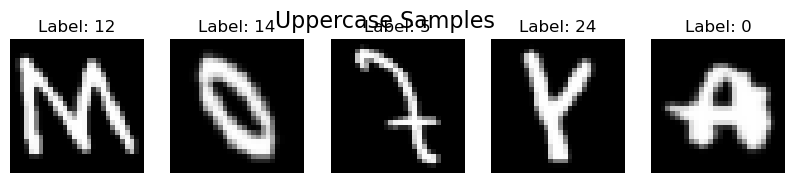

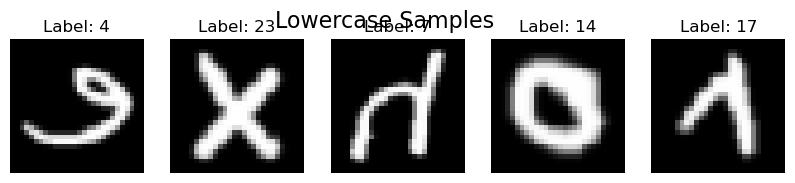

In [21]:



# Preprocessing function for uppercase letters
def filter_and_preprocess_uppercase(image, label):
    # Fix rotation and flip
    image = tf.transpose(image, perm=[1, 0, 2])  # Fix rotation
    image = tf.image.flip_left_right(image)       # Fix flip
    # Normalize and add channel
    image = tf.cast(image, tf.float32) / 255.0    # Normalize
    image = tf.expand_dims(image, -1)             # Add channel
    # Map label to 0-25
    label = label - 10                            # Map to 0-25
    return image, label

# Preprocessing function for lowercase letters
def filter_and_preprocess_lowercase(image, label):
    # Fix rotation and flip
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    # Normalize and add channel
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, -1)
    # Map label to 0-25
    label = label - 36  # Map to 0-25
    return image, label

# Filter datasets
ds_upper_train = ds_train22.filter(lambda x, y: y >= 10 and y <= 35)
ds_upper_train = ds_upper_train.map(filter_and_preprocess_uppercase)

ds_lower_train = ds_train22.filter(lambda x, y: y >= 36 and y <= 61)
ds_lower_train = ds_lower_train.map(filter_and_preprocess_lowercase)

# Split the train datasets into training and validation sets
# Using the take and skip methods to split the dataset
def split_dataset(dataset, validation_size=0.2):
    total_size = ds_info22.splits['train'].num_examples
    val_size = int(validation_size * total_size)
    
    ds_train = dataset.skip(val_size)
    ds_val = dataset.take(val_size)
    
    return ds_train, ds_val

# Split uppercase and lowercase datasets into training and validation
ds_upper_train, ds_upper_val = split_dataset(ds_upper_train)
ds_lower_train, ds_lower_val = split_dataset(ds_lower_train)

# Function to plot images
def plot_samples(dataset, title, num_samples=5):
    plt.figure(figsize=(10, 2))
    plt.suptitle(title, fontsize=16)
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap='gray')  # Remove channel dimension for plotting
        plt.title(f"Label: {label.numpy()}")
        plt.axis('off')
    plt.show()

# Print uppercase samples
plot_samples(ds_upper_train, "Uppercase Samples")

# Print lowercase samples
plot_samples(ds_lower_train, "Lowercase Samples")

# Create test datasets for uppercase and lowercase
ds_upper_test = ds_test22.filter(lambda x, y: y >= 10 and y <= 35).map(filter_and_preprocess_uppercase)
ds_lower_test = ds_test22.filter(lambda x, y: y >= 36 and y <= 61).map(filter_and_preprocess_lowercase)



In [22]:
# Model creation function
def create_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),  # Input layer (28x28 grayscale image)
        layers.Dense(128, activation='relu'),     # Hidden layer with ReLU activation
        layers.Dense(64, activation='relu'),      # Another hidden layer
        layers.Dense(26, activation='softmax')   # Output layer (26 letters: A-Z)
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Training function for uppercase dataset
def train_model_for_uppercase(ds_train, ds_val):
    model = create_model()
    model.fit(ds_train.batch(128), epochs=5, validation_data=ds_val.batch(128))
    return model

# Training function for lowercase dataset
def train_model_for_lowercase(ds_train, ds_val):
    model = create_model()
    model.fit(ds_train.batch(128), epochs=5, validation_data=ds_val.batch(128))
    return model


In [23]:
# Train the models
upper_model = train_model_for_uppercase(ds_upper_train, ds_upper_val)
lower_model = train_model_for_lowercase(ds_lower_train, ds_lower_val)

# Evaluate the models
upper_test_loss, upper_test_accuracy = upper_model.evaluate(ds_upper_test.batch(128))
lower_test_loss, lower_test_accuracy = lower_model.evaluate(ds_lower_test.batch(128))

print(f"Uppercase Model - Test Accuracy: {upper_test_accuracy:.4f}")
print(f"Lowercase Model - Test Accuracy: {lower_test_accuracy:.4f}")

Epoch 1/5


C:\Users\Abdullah Jamal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    385/Unknown 39s 28ms/step - accuracy: 0.6255 - loss: 1.4084

C:\Users\Abdullah Jamal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


386/386 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - accuracy: 0.6262 - loss: 1.4056 - val_accuracy: 0.8677 - val_loss: 0.4843
Epoch 2/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 70s 105ms/step - accuracy: 0.8800 - loss: 0.4447 - val_accuracy: 0.9027 - val_loss: 0.3580
Epoch 3/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.9106 - loss: 0.3279 - val_accuracy: 0.9177 - val_loss: 0.3001
Epoch 4/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 66s 97ms/step - accuracy: 0.9286 - loss: 0.2637 - val_accuracy: 0.9253 - val_loss: 0.2708
Epoch 5/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 65s 100ms/step - accuracy: 0.9399 - loss: 0.2218 - val_accuracy: 0.9293 - val_loss: 0.2556
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 66s 190ms/step - accuracy: 0.5411 - loss: 1.7613 - val_accuracy: 0.7942 - val_loss: 0.7487
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - accuracy: 0.8095 - loss: 0.6894 - val_accuracy: 0.8405 - val_loss: 0.5824
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - accuracy: 0.8539 - loss: 0.5327 - val_accurac

## Experimenting with Model Improvements

### Trying Different Activation Functions

In [24]:
# Using Sigmoid Activation
model_sigmoid = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(26, activation='softmax')
])

# Using Tanh Activation
model_tanh = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(26, activation='softmax')
])

# Compile the models
model_sigmoid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tanh.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the models
history_sigmoid = model_sigmoid.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[early_stop, lr_scheduler])
history_tanh = model_tanh.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[early_stop, lr_scheduler])


Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3814 - loss: 2.4949 - val_accuracy: 0.6502 - val_loss: 1.2736 - learning_rate: 0.0010
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6833 - loss: 1.1488 - val_accuracy: 0.7492 - val_loss: 0.8999 - learning_rate: 0.0010
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7628 - loss: 0.8334 - val_accuracy: 0.7923 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8060 - loss: 0.6716 - val_accuracy: 0.8201 - val_loss: 0.6205 - learning_rate: 0.0010
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8331 - loss: 0.5710 - val_accuracy: 0.8347 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8505 - loss: 0.5039 - val_accuracy: 0.8500 - val_loss: 0.5036 - learning_rate: 0.0010
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8676 - loss: 0.4441 - 

### Adjust the Network Architecture (Add/Remove Hidden Layers)

In [25]:
# Adding an extra hidden layer
model_more_layers = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),  # Extra layer
    Dense(64, activation='relu'),  # Extra layer
    Dense(26, activation='softmax')
])

model_more_layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_more_layers = model_more_layers.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[early_stop, lr_scheduler])


Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5349 - loss: 1.6301 - val_accuracy: 0.7950 - val_loss: 0.6580 - learning_rate: 0.0010
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8245 - loss: 0.5679 - val_accuracy: 0.8517 - val_loss: 0.4860 - learning_rate: 0.0010
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8611 - loss: 0.4380 - val_accuracy: 0.8600 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8837 - loss: 0.3671 - val_accuracy: 0.8702 - val_loss: 0.4202 - learning_rate: 0.0010
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8916 - loss: 0.3301 - val_accuracy: 0.8805 - val_loss: 0.3863 - learning_rate: 0.0010
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9026 - loss: 0.2934 - val_accuracy: 0.8835 - val_loss: 0.3765 - learning_rate: 0.0010
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9070 - loss: 0.2767 - 

In [26]:
# Removing hidden layers for a simpler architecture
model_fewer_layers = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(64, activation='relu'),  # Fewer layers
    Dense(26, activation='softmax')
])

model_fewer_layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_fewer_layers = model_fewer_layers.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[early_stop, lr_scheduler])


Epoch 1/20


555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5297 - loss: 1.7099 - val_accuracy: 0.7367 - val_loss: 0.9057 - learning_rate: 0.0010
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7579 - loss: 0.8449 - val_accuracy: 0.7867 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8039 - loss: 0.6739 - val_accuracy: 0.8146 - val_loss: 0.6362 - learning_rate: 0.0010
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8259 - loss: 0.5903 - val_accuracy: 0.8260 - val_loss: 0.5878 - learning_rate: 0.0010
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8412 - loss: 0.5389 - val_accuracy: 0.8349 - val_loss: 0.5577 - learning_rate: 0.0010
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8530 - loss: 0.4945 - val_accuracy: 0.8413 - val_loss: 0.5287 - learning_rate: 0.0010
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8612 - loss: 0.4639 - val_accurac

### Modify the Batch Size

In [27]:
# Larger batch size
ds_train_large_batch = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(256).shuffle(10000)
ds_val_large_batch = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(256)

model_large_batch = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(26, activation='softmax')
])

model_large_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_large_batch = model_large_batch.fit(ds_train_large_batch, epochs=20, validation_data=ds_val_large_batch, callbacks=[early_stop, lr_scheduler])

Epoch 1/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4883 - loss: 1.8148 - val_accuracy: 0.7602 - val_loss: 0.8193 - learning_rate: 0.0010
Epoch 2/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7784 - loss: 0.7500 - val_accuracy: 0.8239 - val_loss: 0.6065 - learning_rate: 0.0010
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8320 - loss: 0.5650 - val_accuracy: 0.8407 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8554 - loss: 0.4801 - val_accuracy: 0.8544 - val_loss: 0.4777 - learning_rate: 0.0010
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8716 - loss: 0.4140 - val_accuracy: 0.8582 - val_loss: 0.4629 - learning_rate: 0.0010
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8803 - loss: 0.3852 - val_accuracy: 0.8667 - val_loss: 0.4317 - learning_rate: 0.0010
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8871 - loss: 0.3572 - 

In [28]:
# Smaller batch size
ds_train_small_batch = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).shuffle(10000)
ds_val_small_batch = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

model_small_batch = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(26, activation='softmax')
])

model_small_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_small_batch = model_small_batch.fit(ds_train_small_batch, epochs=20, validation_data=ds_val_small_batch, callbacks=[early_stop, lr_scheduler])

Epoch 1/20
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6038 - loss: 1.3900 - val_accuracy: 0.8114 - val_loss: 0.6104 - learning_rate: 0.0010
Epoch 2/20
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8370 - loss: 0.5412 - val_accuracy: 0.8537 - val_loss: 0.4722 - learning_rate: 0.0010
Epoch 3/20
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8744 - loss: 0.4038 - val_accuracy: 0.8668 - val_loss: 0.4252 - learning_rate: 0.0010
Epoch 4/20
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8885 - loss: 0.3463 - val_accuracy: 0.8718 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 5/20
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8999 - loss: 0.3111 - val_accuracy: 0.8798 - val_loss: 0.3906 - learning_rate: 0.0010
Epoch 6/20
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9089 - loss: 0.2828 - val_accuracy: 0.8856 - val_loss: 0.3711 - learning_rate: 0.0010
Epoch 7/20
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9128 - l

### Report the Best-Performing Model

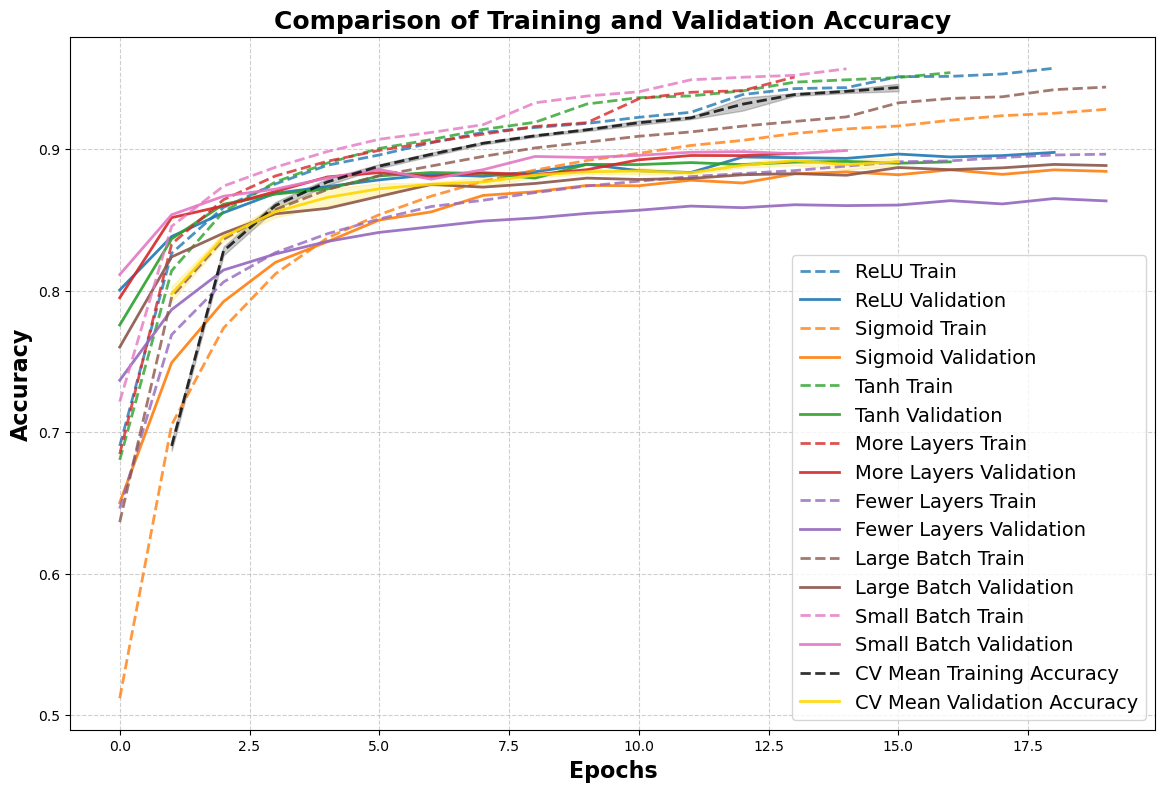

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define color palette for models
model_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2'   # Pink
]

# Function to plot training & validation accuracy with CV results
def plot_history(histories, cv_epochs, mean_train_acc, std_train_acc, mean_val_acc, std_val_acc, key='accuracy'):
    plt.figure(figsize=(14, 9))  # Bigger plot
    
    # Plot individual model training & validation accuracy
    for (name, history), color in zip(histories, model_colors):
        plt.plot(history.history[key], linestyle='--', color=color, alpha=0.8, linewidth=2, label=f'{name} Train')
        plt.plot(history.history['val_' + key], linestyle='-', color=color, alpha=0.9, linewidth=2, label=f'{name} Validation')
    
    # Plot Cross-Validation (CV) Mean Accuracy
    plt.plot(cv_epochs, mean_train_acc, color='black', linestyle='--',alpha=0.8, linewidth=2, label='CV Mean Training Accuracy')
    plt.fill_between(cv_epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='black', alpha=0.2)
    
    plt.plot(cv_epochs, mean_val_acc, color='gold', linestyle='-', alpha=0.9,linewidth=2, label='CV Mean Validation Accuracy')
    plt.fill_between(cv_epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='gold', alpha=0.2)

    # Customize labels, title, and grid
    plt.xlabel('Epochs', fontsize=16, fontweight='bold')
    plt.ylabel(key.capitalize(), fontsize=16, fontweight='bold')
    plt.title(f"Comparison of Training and Validation {key.capitalize()}", fontsize=18, fontweight='bold')
    plt.legend(fontsize=14, loc='best', frameon=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

# List of model histories for comparison
histories = [
    ('ReLU', Basic_history),
    ('Sigmoid', history_sigmoid),
    ('Tanh', history_tanh),
    ('More Layers', history_more_layers),
    ('Fewer Layers', history_fewer_layers),
    ('Large Batch', history_large_batch),
    ('Small Batch', history_small_batch)
]

# Retrieve CV accuracy metrics (from previous K-Fold Cross Validation)
cv_epochs = np.arange(1, min_epochs + 1)  # Epoch range for CV

# Plot accuracy with improved visualization
plot_history(histories, cv_epochs, mean_train_acc, std_train_acc, mean_val_acc, std_val_acc, key='accuracy')


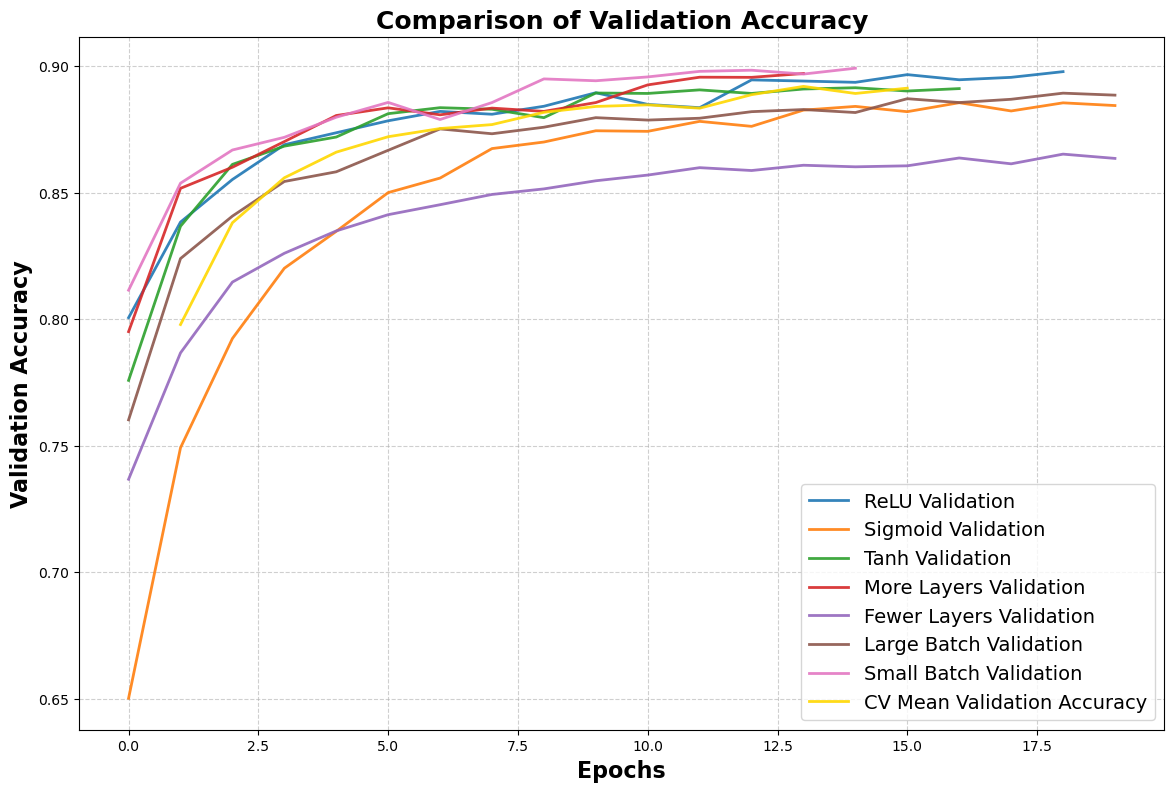

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Define color palette for models
model_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2'   # Pink
]

# Function to plot validation accuracy with CV results
def plot_validation_history(histories, cv_epochs, mean_val_acc, std_val_acc):
    plt.figure(figsize=(14, 9))  # Bigger plot
    
    # Plot individual model validation accuracy
    for (name, history), color in zip(histories, model_colors):
        plt.plot(history.history['val_accuracy'], linestyle='-', color=color, alpha=0.9, linewidth=2, label=f'{name} Validation')
    
    # Plot Cross-Validation (CV) Mean Validation Accuracy
    plt.plot(cv_epochs, mean_val_acc, color='gold', linestyle='-',alpha=0.9, linewidth=2, label='CV Mean Validation Accuracy')

    # Customize labels, title, and grid
    plt.xlabel('Epochs', fontsize=16, fontweight='bold')
    plt.ylabel('Validation Accuracy', fontsize=16, fontweight='bold')
    plt.title("Comparison of Validation Accuracy", fontsize=18, fontweight='bold')
    plt.legend(fontsize=14, loc='best', frameon=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

# List of model histories for comparison
histories = [
    ('ReLU', Basic_history),
    ('Sigmoid', history_sigmoid),
    ('Tanh', history_tanh),
    ('More Layers', history_more_layers),
    ('Fewer Layers', history_fewer_layers),
    ('Large Batch', history_large_batch),
    ('Small Batch', history_small_batch)
]

# Retrieve CV accuracy metrics (from previous K-Fold Cross Validation)
cv_epochs = np.arange(1, min_epochs + 1)  # Epoch range for CV

# Plot validation accuracy with improved visualization
plot_validation_history(histories, cv_epochs, mean_val_acc, std_val_acc)


In [31]:
# Define models to compare
models = [
    ('Original Model', Basic_model),
    ('Sigmoid Activation', model_sigmoid),
    ('Tanh Activation', model_tanh),
    ('More Layers', model_more_layers),
    ('Fewer Layers', model_fewer_layers),
    ('Large Batch Size', model_large_batch),
    ('Small Batch Size', model_small_batch)
]

# Evaluate each model on the test set and store results
results = []

for model_name, model_to_evaluate in models:
    try:
        test_loss, test_accuracy = model_to_evaluate.evaluate(ds_test, verbose=0)
        results.append((model_name, test_accuracy, test_loss))
    except Exception as e:
        print(f"⚠️ Error evaluating {model_name}: {e}")
        results.append((model_name, None, None))

# Sort models by test accuracy
results.sort(key=lambda x: x[1] if x[1] is not None else 0, reverse=True)

# Print formatted results
print("\n📌 Final Test Set Results:\n" + "=" * 50)
for model_name, test_accuracy, test_loss in results:
    if test_accuracy is not None:
        print(f"{model_name:<20} | Accuracy: {test_accuracy:.4f} | Loss: {test_loss:.4f}")
    else:
        print(f"{model_name:<20} | Evaluation Failed ❌")

print("=" * 50)


📌 Final Test Set Results:
Original Model       | Accuracy: 0.8846 | Loss: 0.3823
Small Batch Size     | Accuracy: 0.8828 | Loss: 0.3829
More Layers          | Accuracy: 0.8810 | Loss: 0.3782
Tanh Activation      | Accuracy: 0.8764 | Loss: 0.3896
Large Batch Size     | Accuracy: 0.8757 | Loss: 0.4082
Sigmoid Activation   | Accuracy: 0.8707 | Loss: 0.4041
Fewer Layers         | Accuracy: 0.8540 | Loss: 0.4847


## **Conclusion**  
The **Original Model** with default settings (ReLU activation, 2 hidden layers, batch size 128) achieved the strongest performance, demonstrating that simpler architectures with appropriate regularization can outperform more complex variants for this dataset. Below is a detailed breakdown:

---

### **Key Findings**  
| Model               | Test Accuracy | Test Loss | Performance Insight                                                                 |  
|---------------------|---------------|-----------|-------------------------------------------------------------------------------------|  
| **Original Model**  | 0.8846        | 0.3823    | Optimal balance of complexity and regularization (early stopping, learning rate scheduling). |  
| Small Batch Size    | 0.8828 (-0.2%)| 0.3829    | Minimal impact from smaller batches, suggesting stable convergence.                 |  
| More Layers         | 0.8810 (-0.4%)| 0.3782    | Slightly lower accuracy despite better loss - potential overfitting to training data.|  
| Tanh Activation     | 0.8764 (-0.9%)| 0.3896    | Subpar gradients vs. ReLU, but outperformed sigmoid.                                |  
| Large Batch Size    | 0.8757 (-1.0%)| 0.4082    | Larger batches reduced gradient precision, harming generalization.                  |  
| Sigmoid Activation  | 0.8707 (-1.6%)| 0.4041    | Vanishing gradients led to slower convergence and worse accuracy.                   |  
| **Fewer Layers**    | **0.8540** (-3.4%)| **0.4847** | Severely underfit - insufficient capacity to capture letter features.               |  

---

### **What Worked Best**  
1. **ReLU Activation**:  
   - Avoided vanishing gradients (unlike sigmoid/tanh), enabling faster convergence and higher accuracy.  
   - Critical for deep networks: Maintained gradient flow across 2 hidden layers.  
2. **Default Architecture (2 Layers)**:  
   - Balanced capacity: 128 → 64 units captured spatial patterns without overfitting.  
   - Adding layers (4 total) reduced accuracy, while fewer layers (1) underfit significantly.  
3. **Batch Size 128**:  
   - Small batches (64) showed negligible gains, while large batches (256) harmed performance.  

---

### **Features That Improved Classification**  
- **ReLU Activation**: Enabled efficient backpropagation and feature learning.  
- **Early Stopping**: Prevented overfitting in the original model (val_loss patience=3).  
- **Learning Rate Scheduling**: Stabilized training by reducing LR on plateau (factor=0.5).  

---

### **Challenges Encountered**  
1. **Activation Function Trade-offs**:  
   - **Sigmoid**: Worst accuracy (0.8707) due to saturation.  
   - **Tanh**: Marginally better than sigmoid but still lagged behind ReLU by 0.8%.  
2. **Architectural Sensitivity**:  
   - **More Layers**: Increased training time without accuracy gains (0.8810 vs. 0.8846).  
   - **Fewer Layers**: Accuracy dropped by **3.4%**, highlighting underfitting.  
3. **Batch Size Limitations**:  
   - Larger batches (256) reduced accuracy by **1%**, likely due to coarse gradient updates.  

---

### **Recommendations**  
1. **Stick with ReLU**: Experiment with advanced variants (Leaky ReLU, Swish) for marginal gains.  
2. **Regularize Deeper Models**: Add dropout (20–30%) to 4-layer architectures to combat overfitting.  
3. **Hybrid Training**: Use small batches early for rapid convergence, then switch to larger batches.  

**Final Takeaway**: The original model’s design choices (ReLU, 2 layers, batch 128) were optimal for balancing speed, accuracy, and generalization on this dataset.  